In [3]:
# Import all required packages

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.utils import shuffle

import re
import nltk
nltk.download('stopwords')
import time
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import keras 
from keras.models import Sequential, Model 
from keras import layers
from keras.layers import Dense, Dropout, Input, Embedding

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Read in train data into a dataframe
data = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding="latin1", header=None)
print(data.shape)
data.head(5)

(1600000, 6)


,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Count the number of tweets per sentiment in train Data

print(data[0].value_counts())
print("total ", len(data))

0    800000
4    800000
Name: 0, dtype: int64
total  1600000


In [ ]:
# Data Preprocess Function

def dataPreprocess(text):

    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    text = re.sub(u"(\u2018|\u2019|u2018|u2019|u002)", "'", text)

    url_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = url_pattern.sub(r'', text)

    taguser_pattern = re.compile('@(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = taguser_pattern.sub(r'', text)

    contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
    specials = ["’", "‘", "´", "`", "'"]
    for s in specials:
        text = text.replace(s, "'")

    for key in contraction_mapping:
      text = text.lower()
      text = text.replace(key, contraction_mapping[key])


    textArr = text.split()
    text = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))])

    text = re.sub('[^a-zA-Z]',' ',text) 

    text = text.lower()

    text = text.split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    text = [ps.stem(word) for word in text if not word in set(all_stopwords)]

    return ' '.join(text)

In [ ]:
print(dataPreprocess('@misstoriblack cool , i have no tweet apps  for my razr 2'))

cool tweet app razr


In [ ]:
inputData = shuffle(data,random_state=42)
inputData = inputData[1:700000]

In [ ]:
inputData[0].value_counts()

4    350003
0    349996
Name: 0, dtype: int64

In [ ]:
# Data Proprocessing

inputData[5] = inputData[5].apply(lambda x: dataPreprocess(x))

In [ ]:
inputData.to_csv("/content/preprocessed_data_semeval700000.csv", index=False)

NameError: ignored

In [5]:
dataset_cols = ["target", "ids", "date", "flag", "user", "text"]
preprocessed_data = pd.read_csv('/content/drive/MyDrive/Dataset/preprocessed_data_semeval700000.csv', names=dataset_cols)

# Remove null values from Dataframe
preprocessed_data = preprocessed_data.dropna()

print(preprocessed_data)

        target         ids                          date      flag  \
0            0           1                             2         3   
1            0  1467998485  Mon Apr 06 23:11:14 PDT 2009  NO_QUERY   
2            0  2300048954  Tue Jun 23 13:40:11 PDT 2009  NO_QUERY   
3            0  1993474027  Mon Jun 01 10:26:07 PDT 2009  NO_QUERY   
4            0  2256550904  Sat Jun 20 12:56:51 PDT 2009  NO_QUERY   
...        ...         ...                           ...       ...   
699995       0  1975106381  Sat May 30 14:27:40 PDT 2009  NO_QUERY   
699996       4  1974413652  Sat May 30 13:05:16 PDT 2009  NO_QUERY   
699997       0  2252096148  Sat Jun 20 05:26:36 PDT 2009  NO_QUERY   
699998       4  1970196461  Sat May 30 02:51:14 PDT 2009  NO_QUERY   
699999       0  2263008538  Sat Jun 20 23:44:17 PDT 2009  NO_QUERY   

                   user                                               text  
0                     4                                                  5  
1    

In [6]:
# Get Y value (Predicted values)

y = preprocessed_data['target']
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
# Split train-test dataset

X_train, X_test, y_train, y_test = train_test_split(preprocessed_data['text'], y, test_size = 0.15, random_state = 0)

In [8]:
# Transform text into vector using TFIDF

tfidf = TfidfVectorizer(max_features = 600)
X_train_tf = tfidf.fit_transform(X_train).toarray() 
X_test_tf = tfidf.transform(X_test).toarray()

In [9]:
X_train_tf.shape, X_test_tf.shape, y_train.shape, y_test.shape

((591695, 600), (104417, 600), (591695,), (104417,))

In [10]:
# CNN Sequential Model

from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=600))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               153856    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 12)                780       
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0

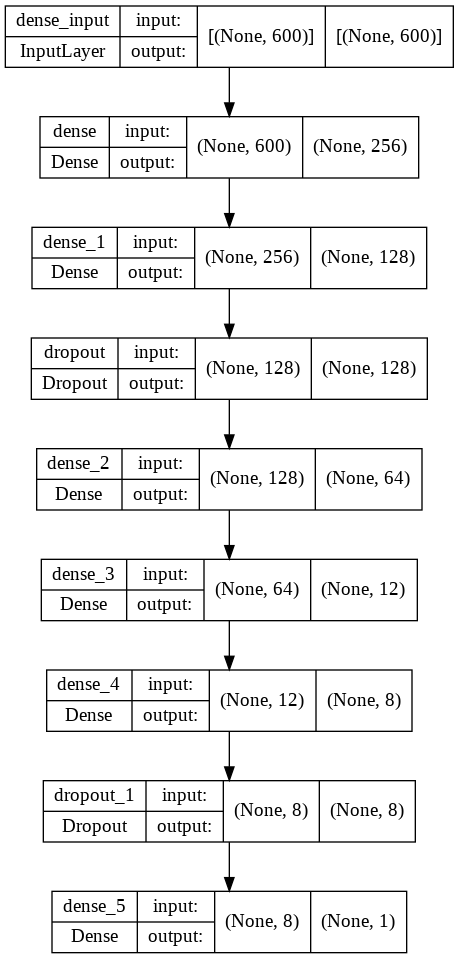

In [11]:
# Save Model Output Image

import tensorflow as tf
tf.keras.utils.plot_model(model, "/content/CNNModel.png", show_shapes=True)

In [12]:
# Execute our Model

history = model.fit(X_train_tf, y_train, epochs=20, batch_size=32,validation_data=(X_test_tf,y_test))

Epoch 1/20
18491/18491 [==============================] - 72s 4ms/step - loss: 0.5469 - accuracy: 0.7270 - val_loss: 0.5090 - val_accuracy: 0.7545
Epoch 2/20
18491/18491 [==============================] - 71s 4ms/step - loss: 0.5300 - accuracy: 0.7401 - val_loss: 0.4984 - val_accuracy: 0.7557
Epoch 3/20
18491/18491 [==============================] - 70s 4ms/step - loss: 0.5205 - accuracy: 0.7477 - val_loss: 0.4921 - val_accuracy: 0.7587
Epoch 4/20
18491/18491 [==============================] - 71s 4ms/step - loss: 0.5117 - accuracy: 0.7537 - val_loss: 0.4945 - val_accuracy: 0.7569
Epoch 5/20
18491/18491 [==============================] - 79s 4ms/step - loss: 0.5034 - accuracy: 0.7596 - val_loss: 0.4951 - val_accuracy: 0.7584
Epoch 6/20
18491/18491 [==============================] - 70s 4ms/step - loss: 0.4944 - accuracy: 0.7655 - val_loss: 0.4987 - val_accuracy: 0.7555
Epoch 7/20
18491/18491 [==============================] - 71s 4ms/step - loss: 0.4863 - accuracy: 0.7717 - val_loss: 0

In [13]:
# Print Training and Testing Accuracy

loss, accuracy = model.evaluate(X_train_tf, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_tf, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8432
Testing Accuracy:  0.7370


In [14]:
# Predict Model Accuracy

y_pred_new = model.predict(X_test_tf)
y_pred_nn = np.where(y_pred_new>0.5,1,0)
print("Accuracy:\n", accuracy_score(y_test, y_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))
print("Classification Report:\n", classification_report(y_test, y_pred_nn))

Accuracy:
 0.7370064261566603
Confusion Matrix:
 [[37013 15346]
 [12115 39943]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.71      0.73     52359
           1       0.72      0.77      0.74     52058

    accuracy                           0.74    104417
   macro avg       0.74      0.74      0.74    104417
weighted avg       0.74      0.74      0.74    104417



<Figure size 432x288 with 0 Axes>

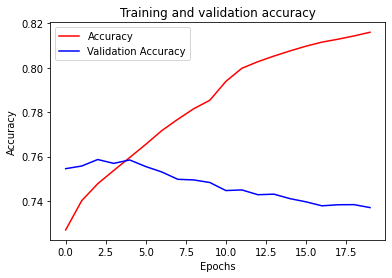

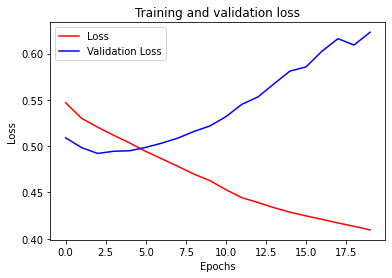

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

In [16]:
# Calculated Accuracy

CNN = accuracy_score(y_test, y_pred_nn)

print(str('CNN {:04.2f}'.format((CNN)* 100))+'%')

CNN 73.70%
